# Plotting DE results
-  PCA plots of results
-  MA plots of results
- Heatmaps of vsd normalized data

In [2]:
library('ComplexHeatmap')
library('ggpubr')
library('tidyverse')
library('gridExtra')
library('viridis')
library('matrixStats')
library('PCAtools')
library('multipanelfigure')
library('magrittr')
library('cowplot')
library('circlize')

## 1. Read in data
read in vsd normalized data and log fold change data for all data and kegg-summerized counts each. ko-definition table, ko-orf table and sub categories-definition table. 

In [3]:
read.vsd.k <- function(org){
    vsd.k <- read.csv(paste('../expression_analysis/vsd_files/', org,'vsd.kegg.csv',sep=''))
    colnames(vsd.k)[1] <- 'ko_id'
    colnames(vsd.k) <- gsub('X', '', colnames(vsd.k))
    vsd.k
    }

## vsd normalized data
vsd.4 = read.csv('../expression_analysis/vsd_files/04vsd.csv')
vsd.4.k = read.vsd.k('04')

vsd.8 = read.csv('../expression_analysis/vsd_files/08vsd.csv')
vsd.8.k = read.vsd.k('08')

vsd.6 = read.csv('../expression_analysis/vsd_files/06vsd.csv')
vsd.6.k = read.vsd.k('06')

vsd.13 = read.csv('../expression_analysis/vsd_files/13vsd.csv')
vsd.13.k = read.vsd.k('13')


#lfcShrink data
## 04:
lfc4.AvL <- read.csv("../expression_analysis/de_res_files/lfc4.AvL.csv")
lfc4.k.AvL <- read.csv("../expression_analysis/de_res_files/lfc4.AvL.kegg.csv")

## 08:
lfc8.AvL <- read.csv("../expression_analysis/de_res_files/lfc8.AvL.csv")
lfc8.HvL <- read.csv("../expression_analysis/de_res_files/lfc8.HvL.csv")
lfc8.k.AvL <- read.csv("../expression_analysis/de_res_files/lfc8.AvL.kegg.csv")
lfc8.k.HvL <- read.csv("../expression_analysis/de_res_files/lfc8.HvL.kegg.csv")

## 06:
lfc6.AvL <- read.csv("../expression_analysis/de_res_files/lfc6.AvL.csv")
lfc6.HvL <- read.csv("../expression_analysis/de_res_files/lfc6.HvL.csv")
lfc6.k.AvL <- read.csv("../expression_analysis/de_res_files/lfc6.AvL.kegg.csv")
lfc6.k.HvL <- read.csv("../expression_analysis/de_res_files/lfc6.HvL.kegg.csv")

## 13:
lfc13.AvL <- read.csv("../expression_analysis/de_res_files/lfc13.AvL.csv")
lfc13.HvL <- read.csv("../expression_analysis/de_res_files/lfc13.HvL.csv")
lfc13.k.AvL <- read.csv("../expression_analysis/de_res_files/lfc13.AvL.kegg.csv")
lfc13.k.HvL <- read.csv("../expression_analysis/de_res_files/lfc13.HvL.kegg.csv")

In [22]:
## Ko definitions and mappings
ko.def = read.csv('../expression_analysis/kegg_files/ko_def.csv')
ko.def$ko_id = str_replace(ko.def$ko_id, 'isip1a', 'isip_1a')
ko4 = read.csv('../expression_analysis/kegg_files/ko4_ls.csv')
ko8 = read.csv('../expression_analysis/kegg_files/ko8_ls.csv')
ko6 = read.csv('../expression_analysis/kegg_files/ko6_ls.csv')
ko13 = read.csv('../expression_analysis/kegg_files/ko13_ls.csv')
#mod = read.csv('../expression_analysis/kegg_files/all.mod.csv')
all.path = read.csv('../expression_analysis/kegg_files/pathwaysHeatMap.csv')

In [5]:
#reorder vsd df's so they are correct in heatmaps
colnames(vsd.4.k)
vsd.4.k = vsd.4.k %>% select('ko_id','pFe21_9A','pFe21_9B','pFe21_9C','add_backA','add_backB')
colnames(vsd.4.k)
colnames(vsd.8.k)
vsd.8.k = vsd.8.k %>% select('ko_id','pFe19A','pFe19B','pFe19C','pFe21_9A','pFe21_9B','pFe21_9C','add_backB','add_backC')
colnames(vsd.8.k)
colnames(vsd.6.k)
vsd.6.k = vsd.6.k %>% select('ko_id','pFe19A','pFe19B','pFe19C','pFe21_9A','pFe21_9B','pFe21_9C','add_backA','add_backB','add_backC')
colnames(vsd.6.k)
colnames(vsd.13.k)
vsd.13.k = vsd.13.k %>% select('ko_id','pFe19A','pFe19B','pFe19C','pFe21_9A','pFe21_9B','pFe21_9C','add_backA','add_backB')
colnames(vsd.13.k)

[1] "ko_id"     "add_backA" "add_backB" "pFe21_9A"  "pFe21_9B"  "pFe21_9C"

[1] "ko_id"     "pFe21_9A"  "pFe21_9B"  "pFe21_9C"  "add_backA" "add_backB"

[1] "ko_id"     "add_backB" "add_backC" "pFe19A"    "pFe19B"    "pFe19C"   
[7] "pFe21_9A"  "pFe21_9B"  "pFe21_9C"

[1] "ko_id"     "pFe19A"    "pFe19B"    "pFe19C"    "pFe21_9A"  "pFe21_9B" 
[7] "pFe21_9C"  "add_backB" "add_backC"

[1] "ko_id"     "add_backA" "add_backB" "add_backC" "pFe19A"    "pFe19B"   
 [7] "pFe19C"    "pFe21_9A"  "pFe21_9B"  "pFe21_9C"

[1] "ko_id"     "pFe19A"    "pFe19B"    "pFe19C"    "pFe21_9A"  "pFe21_9B" 
 [7] "pFe21_9C"  "add_backA" "add_backB" "add_backC"

[1] "ko_id"     "add_backA" "add_backB" "pFe19A"    "pFe19B"    "pFe19C"   
[7] "pFe21_9A"  "pFe21_9B"  "pFe21_9C"

[1] "ko_id"     "pFe19A"    "pFe19B"    "pFe19C"    "pFe21_9A"  "pFe21_9B" 
[7] "pFe21_9C"  "add_backA" "add_backB"

# MA plots
1. Normal ma
2. ma with summs to kegg module level
3. plotly ma
4. ?
## All Orfs MA

In [ ]:
nrow(filter(AvL.k8, padj<=0.05))
nrow(filter(AvL.k8, padj>=0.05))
nrow(filter(lfc8.k.AvL, padj<=0.05))
nrow(filter(lfc8.k.AvL, padj>=0.05))


In [5]:
## Function to plot and lfcShrink de dataframe 
# color genes by sub_category

ma.plot <- function(lfc, title){
    p <- ggmaplot(
        lfc, 
        main = title,
        fdr = 0.05, fc = 2, 
        size = 0.4,
        palette = c("#B31B21", "#1465AC", "darkgray"),
        #genenames = as.vector(lfc$symbol),
        
        legend = "top", 
        font.legend = "bold",
        font.main = "bold",
        ggtheme = ggplot2::theme_minimal()) 
    ggsave(filename = paste(title, ".png", sep=""), p, path="../figures", width = 10, height = 10)
    print(p)
}


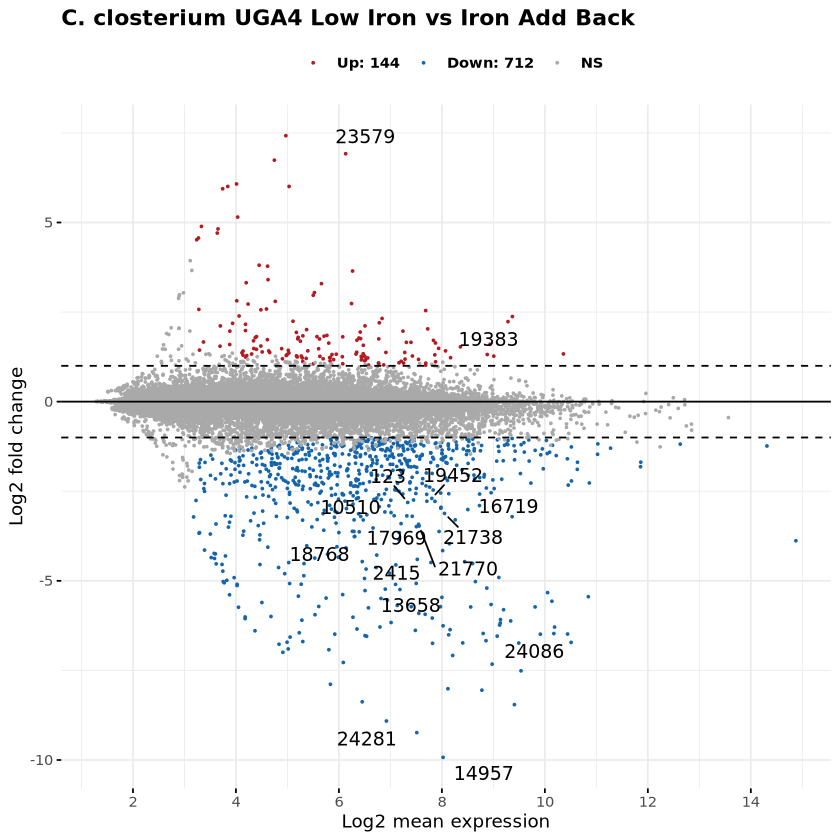

In [6]:
ma.plot(lfc4.AvL, "C. closterium UGA4 Low Iron vs Iron Add Back")

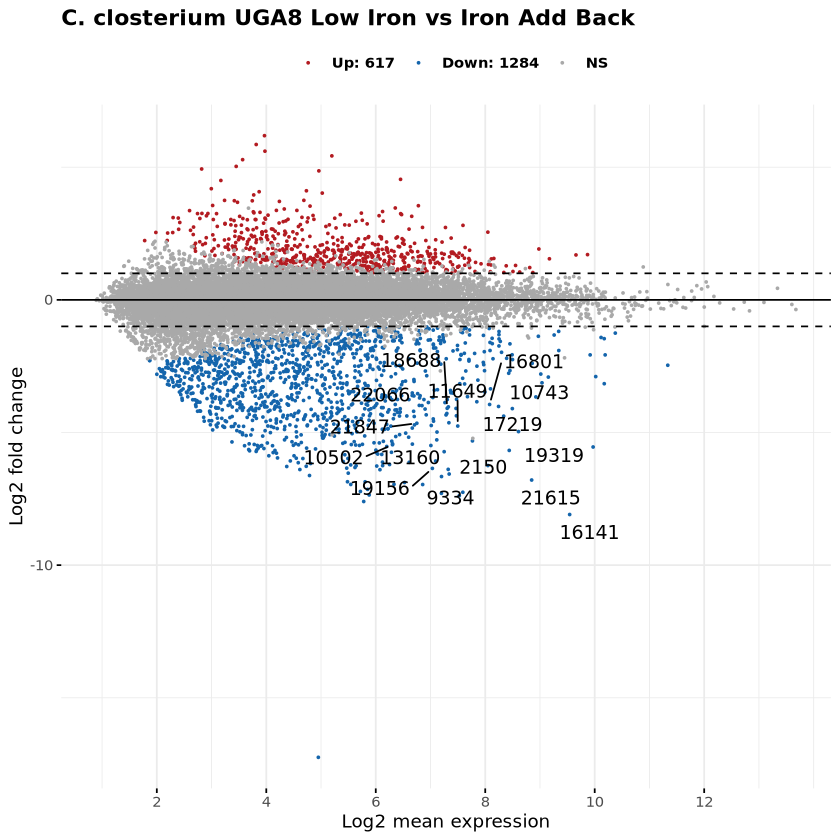

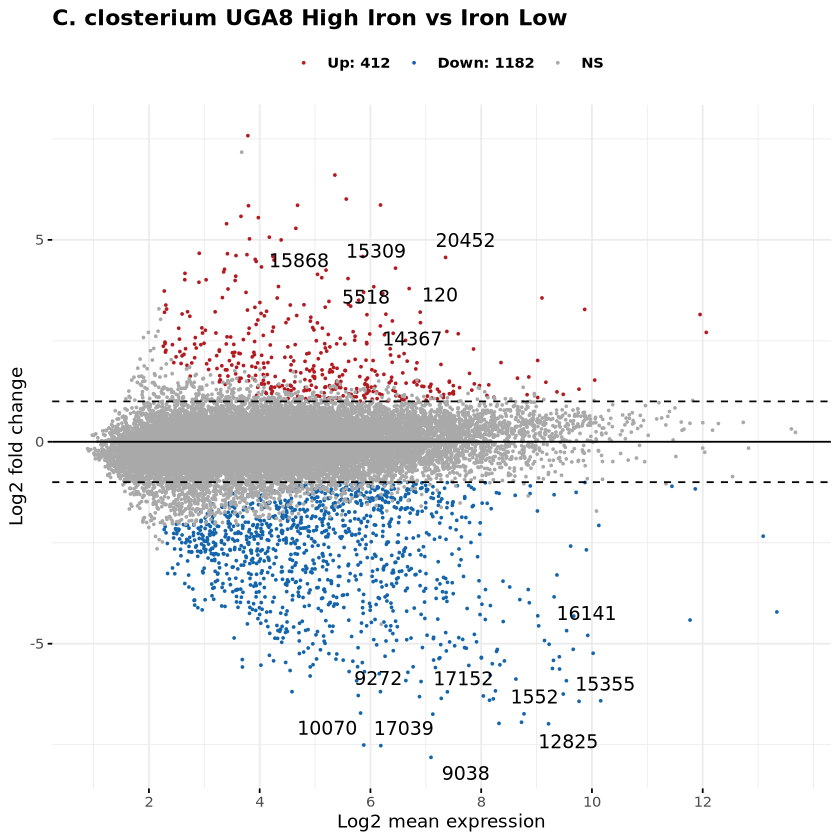

In [7]:
ma.plot(lfc8.AvL,  "C. closterium UGA8 Low Iron vs Iron Add Back")
ma.plot(lfc8.HvL,   "C. closterium UGA8 High Iron vs Iron Low")

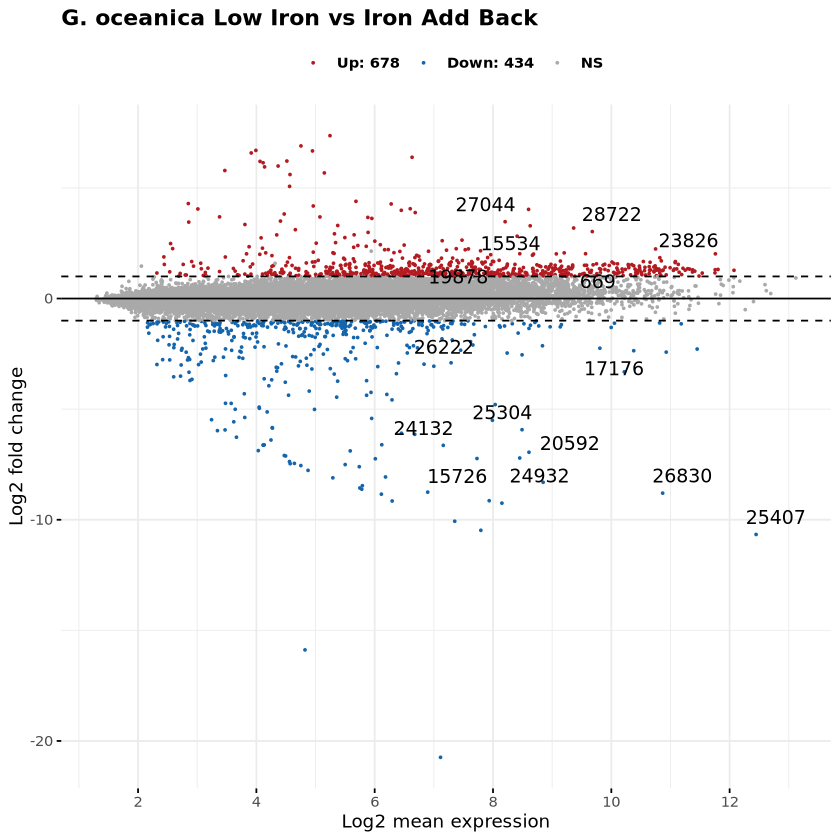

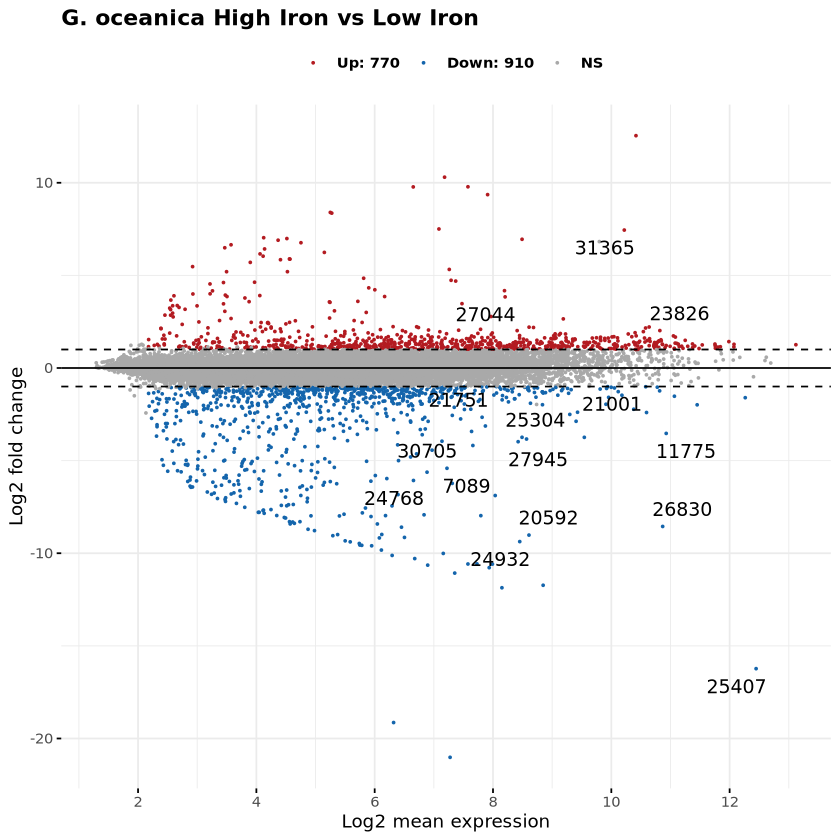

In [8]:
ma.plot(lfc6.AvL,  "G. oceanica Low Iron vs Iron Add Back")
ma.plot(lfc6.HvL,  "G. oceanica High Iron vs Low Iron ")

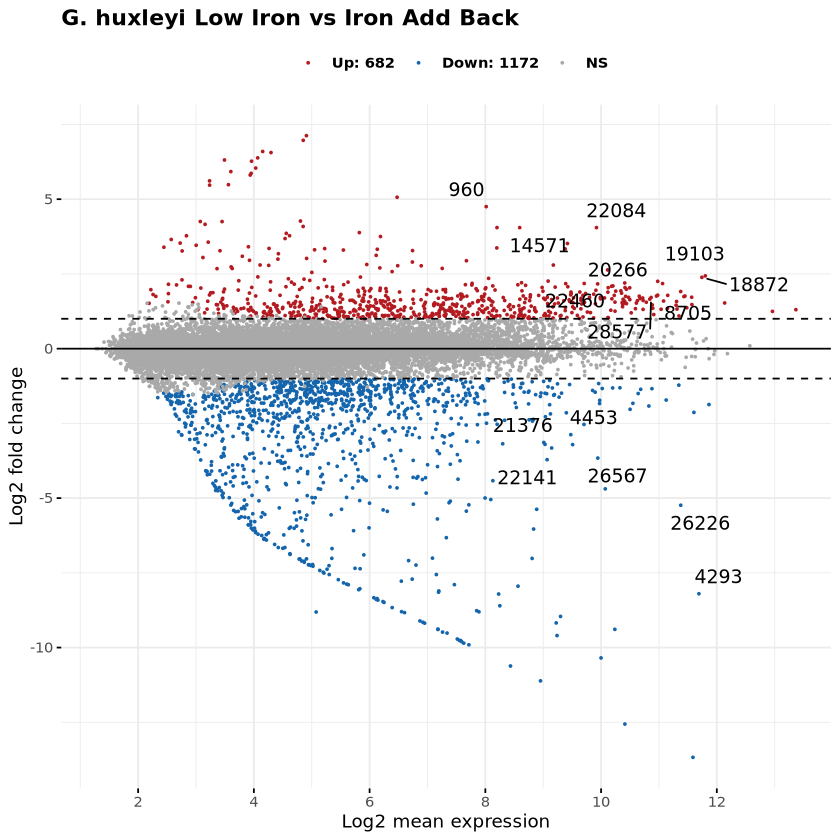

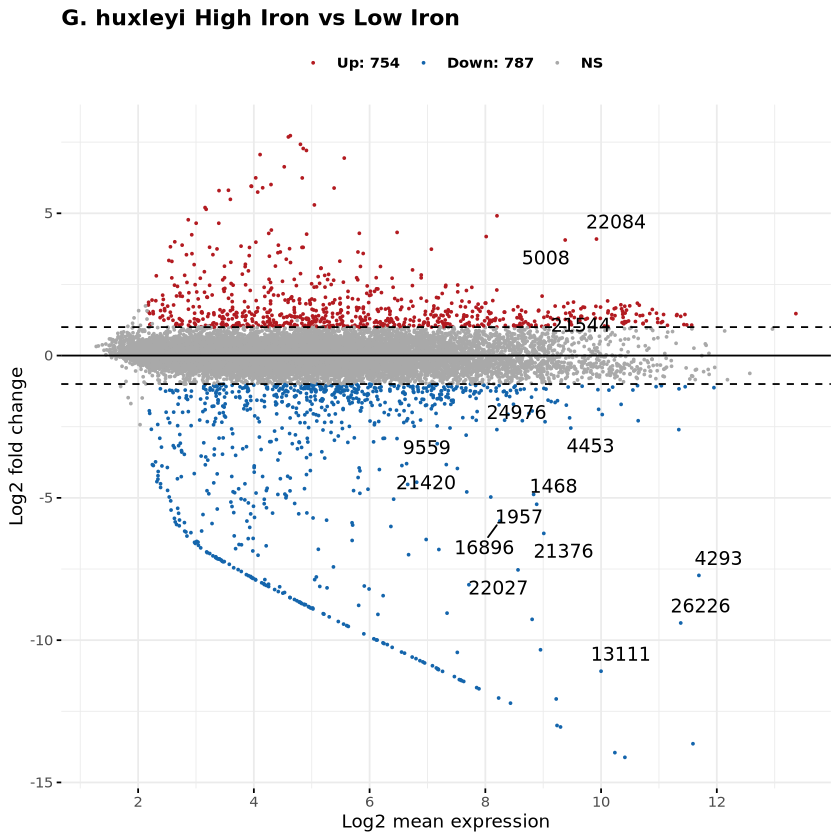

In [9]:
ma.plot(lfc13.AvL,  "G. huxleyi Low Iron vs Iron Add Back") # top= add back, bottom= low fe
ma.plot(lfc13.HvL,  "G. huxleyi High Iron vs Low Iron") #top=high fe, bottom = low fe

## Kegg-summerized counts MA
### labeling top # kegg genes (top DE) 

In [10]:
#for kegg level summarized:
ma.kegg <- function(lfc, comparison, organism, name) {
    lfc <- left_join(lfc, ko.def, by='ko_id')
    p <- ggmaplot(
        lfc, 
        main = paste(comparison),
        font.main=c(15,'bold','black'),
        submain=organism,
        font.submain= c(15,'bold.italic','black'),
        fdr = 0.05, fc = 2, 
        size = 4,
        #top=30,
        palette = c("#B31B21", "#1465AC", "darkgray"),
        genenames = as.vector(lfc$symbol),
        select.top.method='fc',
        legend = "top",
        font.label = c("bold", 10), 
        label.rectangle = T,
        font.legend = "bold", ggtheme=theme_minimal())
            
    ggsave(filename = paste(name, ".png", sep=""),p,path="../figures/", width = 10, height = 10)
    p

}

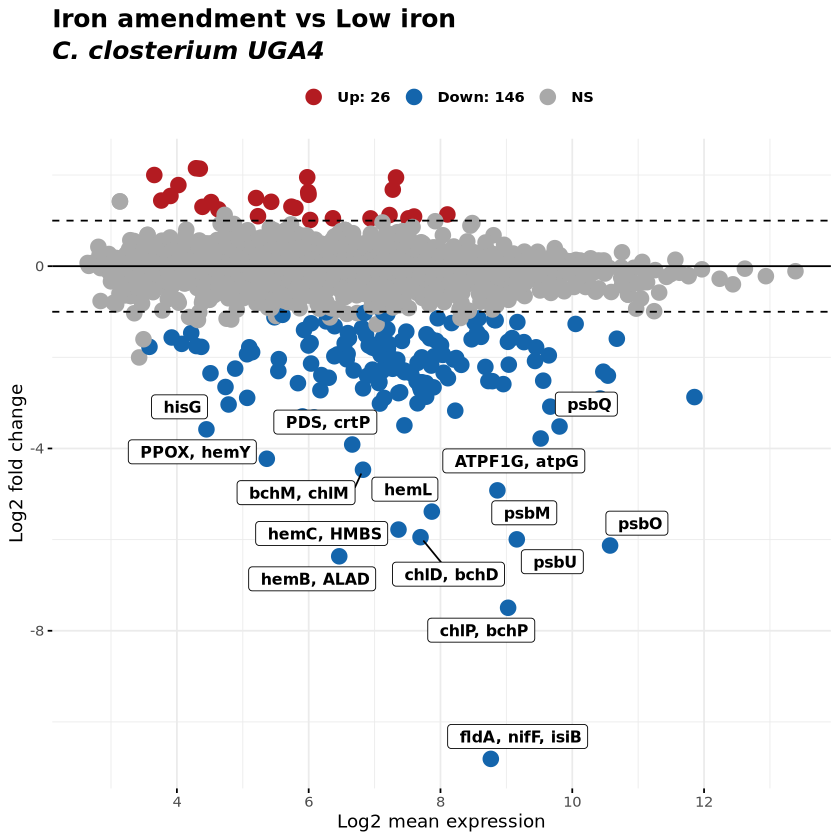

In [11]:
ma.kegg(lfc4.k.AvL, "Iron amendment vs Low iron",'C. closterium UGA4', "MA.4k")

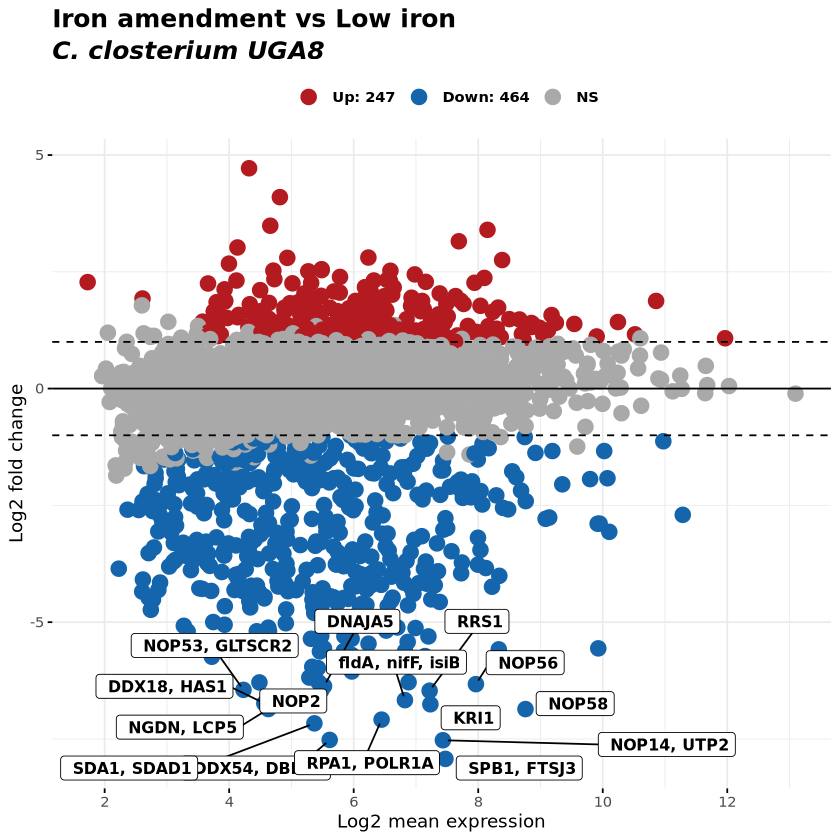

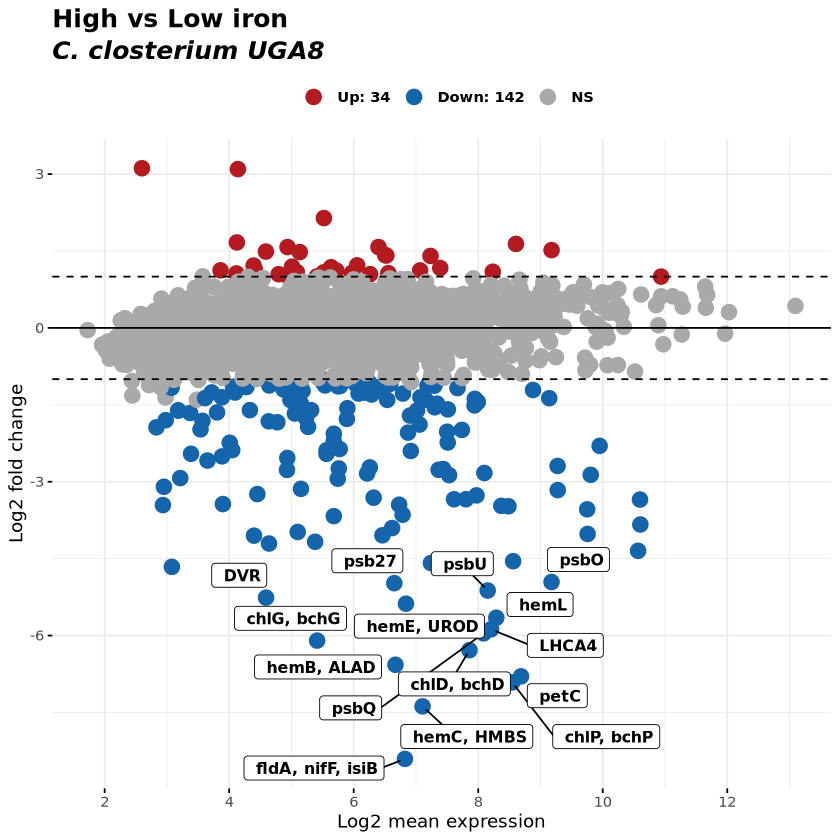

In [12]:
ma.kegg(lfc8.k.AvL,'Iron amendment vs Low iron','C. closterium UGA8', 'MA.8k.AL')
ma.kegg(lfc8.k.HvL,'High vs Low iron','C. closterium UGA8', 'MA.8k.HL')

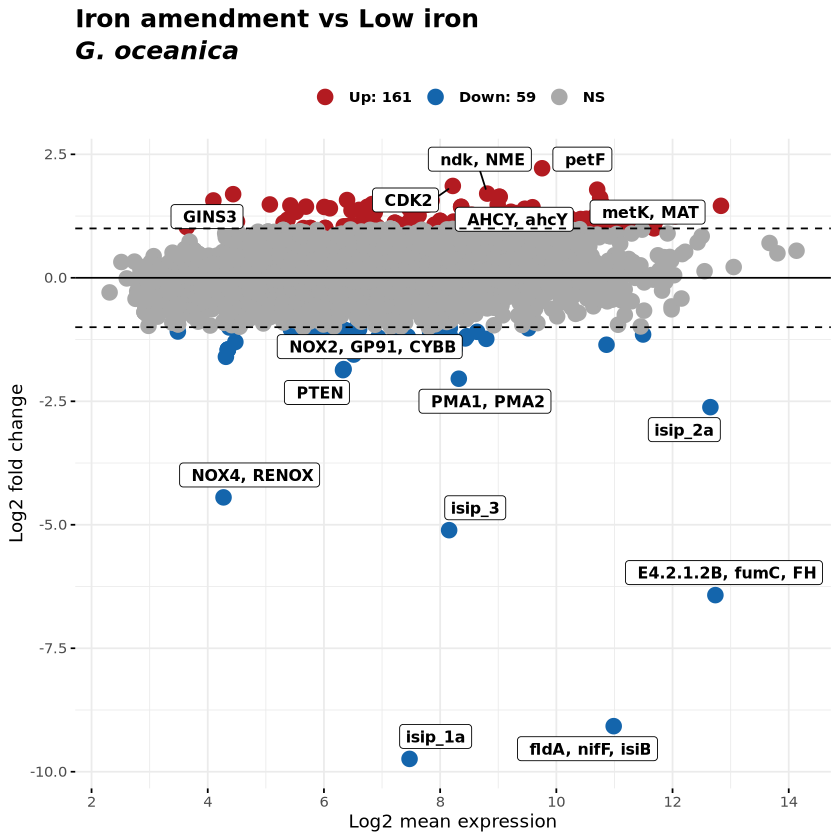

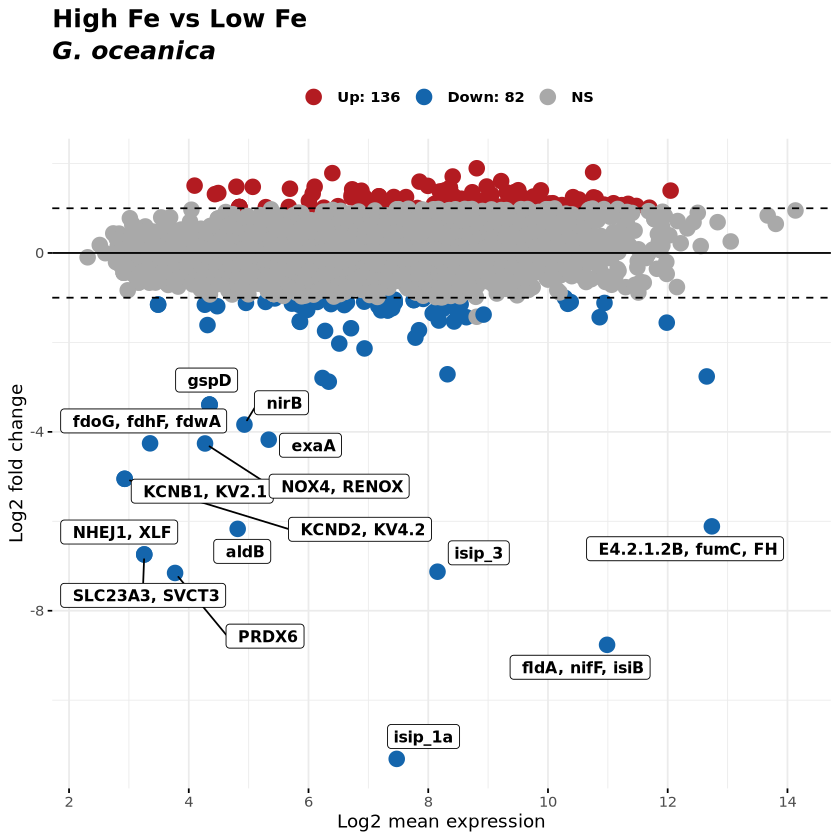

In [13]:
ma.kegg(lfc6.k.AvL, 'Iron amendment vs Low iron', 'G. oceanica','MA.6k.AL')
ma.kegg(lfc6.k.HvL, "High Fe vs Low Fe", 'G. oceanica','MA.6k.HL')

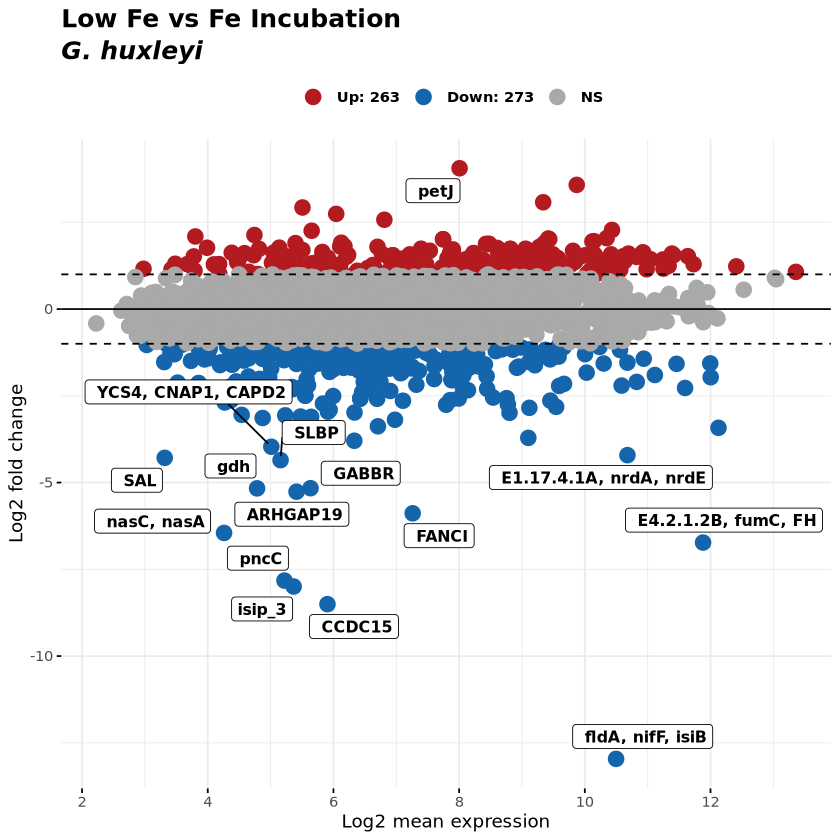

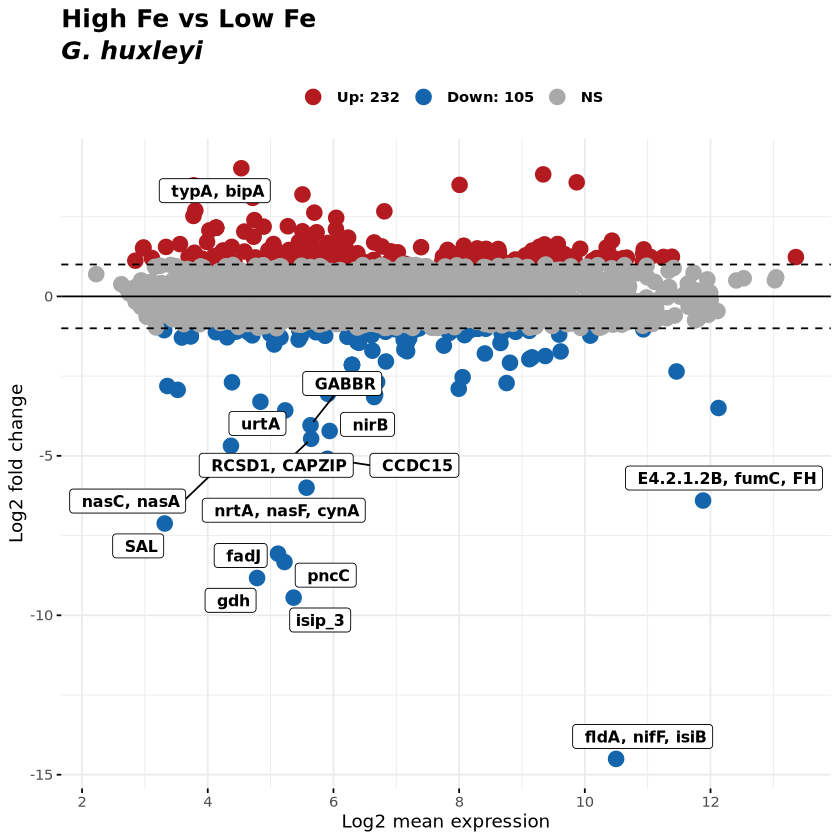

In [14]:
ma.kegg(lfc13.k.AvL, 'Low Fe vs Fe Incubation','G. huxleyi', 'MA.13k.AL')
ma.kegg(lfc13.k.HvL, 'High Fe vs Low Fe', 'G. huxleyi', 'MA.13k.HL')

### labeling genes of interest
I need to make a list of kegg genes I wish to point out. Maybe I can obtain this list from the heatmaps? Or I can select them based on processes I want to highlight. 
ideas for list so far:
- isip's
- nitrogen transporter
- ammonium transporter
- flavodoxin
- ferredoxin
- psi and psii

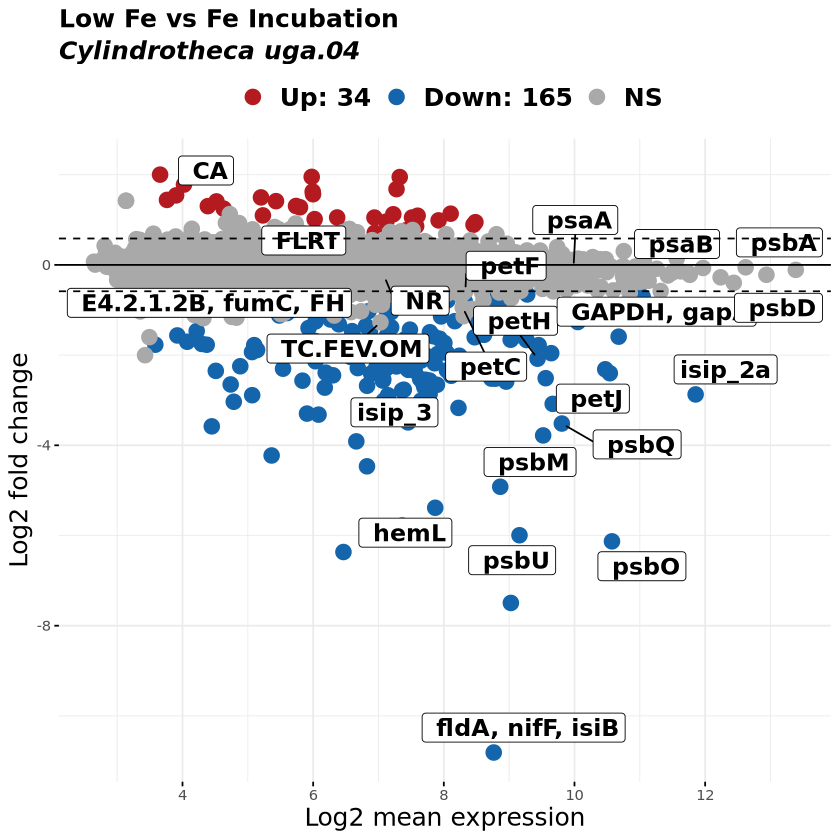

ERROR: Error in eval(expr, envir, enclos): object 'lfc8.k.AvH' not found


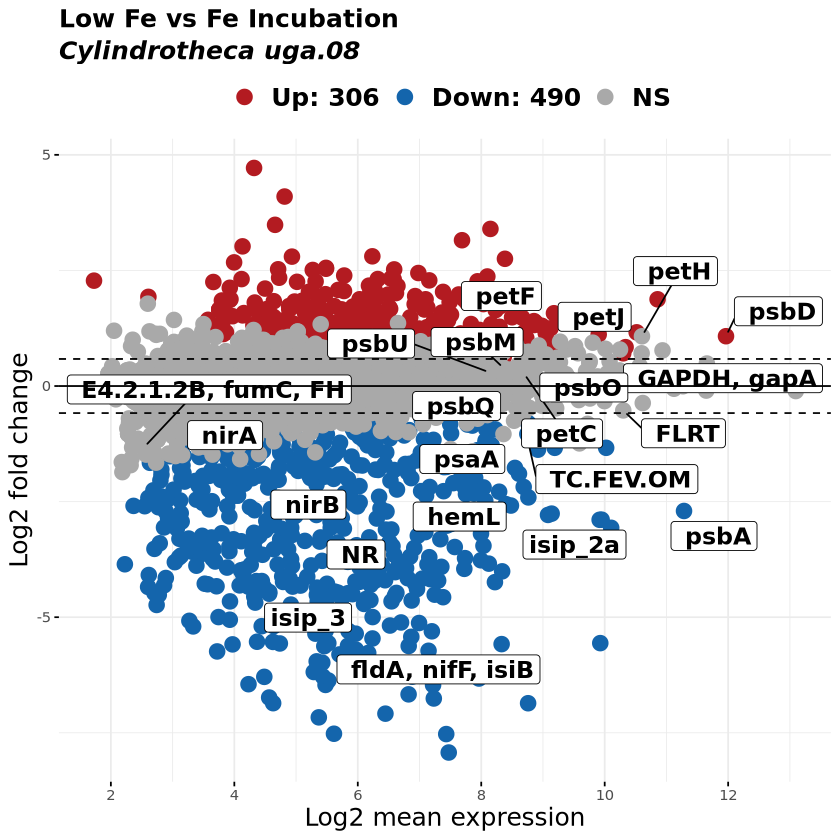

In [15]:
genes.list=c(' fldA, nifF, isiB','isip_1','isip_2','isip_2a','isip_3',' petF', ' petJ',' nirA',' nirB',' NR', ' CA',
            ' psbA',' psbU',' psbQ',' psbO',' petC',' petH',' petJ',' hemL',' TC.FEV.OM',' psbM', ' GAPDH, gapA',
             ' FLRT',' E4.2.1.2B, fumC, FH',' psbD',' psaA',' psaB')

ma.kegg.manual <- function(lfc, comparison, organism, name) {
    lfc <- left_join(lfc, ko.def, by='ko_id')
    p <- ggmaplot(
        lfc, 
        main = paste(comparison),
        font.main=c(15,'bold','black'),
        submain=organism,
        font.submain= c(15,'bold.italic','black'),
        fdr = 0.05, #fc = 1, 
        size = 4,
        top=0,
        label.select=genes.list,
        #palette = c("#B31B21", "#1465AC", "darkgray"),
        genenames = as.vector(lfc$symbol),
        select.top.method='padj',
        legend = "top",
        font.label = c(15,"bold"), 
        font.x=15,
        font.y=15,
        label.rectangle = TRUE,
        font.legend = c(15,"bold"), ggtheme=theme_minimal())
            
   ggsave(filename = paste(name, ".png", sep=""), p, 
          path="/work/nclab/lucy/SAB/Annotation/figs", width = 10, height = 10)
    p

}

ma.kegg.manual(lfc4.k.AvL, 'Low Fe vs Fe Incubation','Cylindrotheca uga.04', 'MA.4.manual.AL')

ma.kegg.manual(lfc8.k.AvL, 'Low Fe vs Fe Incubation','Cylindrotheca uga.08', 'MA.8.manual.AL')
ma.kegg.manual(lfc8.k.AvH, 'High Fe vs Fe Incubation', 'Cylindrotheca uga.08','MA.8.manual.AH') 
ma.kegg.manual(lfc8.k.HvL, 'High Fe vs Low Fe', 'Cylindrotheca uga.08', 'MA.8.manual.HL')

ma.kegg.manual(lfc6.k.AvL, 'Low Fe vs Fe Incubation','Gephyrocapsa oceanica', 'MA.6.manual.AL')
ma.kegg.manual(lfc6.k.AvH, 'High Fe vs Fe Incubation', 'Gephyrocapsa oceanica','MA.6.manual.AH') 
ma.kegg.manual(lfc6.k.HvL, 'High Fe vs Low Fe', 'Gephyrocapsa oceanica', 'MA.6.manual.HL')

ma.kegg.manual(lfc13.k.AvL, 'Low Fe vs Fe Incubation','Emiliania huxleyi', 'MA.13.manual.AL')
ma.kegg.manual(lfc13.k.AvH, 'High Fe vs Fe Incubation', 'Emiliania huxleyi','MA.13.manual.AH') 
ma.kegg.manual(lfc13.k.HvL, 'High Fe vs Low Fe', 'Emiliania huxleyi', 'MA.13.manual.HL')

In [ ]:
#vsd.13=pivot_longer(vsd.13,cols=!orfs,names_to = 'treatment', values_to='counts')
vsd.13$treatment=str_remove(vsd.13$treatment, '[ABC]')

vsd.13$iron[vsd.13$treatment=='pFe19']='High Fe'
vsd.13$iron[vsd.13$treatment=='pFe21_9']='Low Fe'
vsd.13$iron[vsd.13$treatment=='add_back']='Add Back'
head(vsd.13)

# Heatmaps 

## all orfs

In [122]:
filter(lfc4.AvL, orfs %in% rho.pfam$orfs&padj<0.05) #no
filter(lfc6.HvL, orfs %in% rho.pfam$orfs&padj<0.05) 
filter(lfc6.AvL, orfs %in% rho.pfam$orfs&padj<0.05) #no
filter(lfc13.HvL, orfs %in% rho.pfam$orfs&padj<0.05)
filter(lfc13.AvL, orfs %in% rho.pfam$orfs&padj<0.05) #no 

orfs,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


orfs,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NODE_4760_length_3106_cov_63.873393_g2102_i0.p3,52.82221,-0.9484864,0.4222018,0.001342001,0.01975069


orfs,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


orfs,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NODE_3596_length_2981_cov_19.900619_g1756_i0.p2,3.597263,1.478476,1.9964641,0.0029389478,0.031914813
NODE_3961_length_2893_cov_21.811348_g1756_i1.p1,27.692000,1.279241,0.4600838,0.0000586002,0.001236927


orfs,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


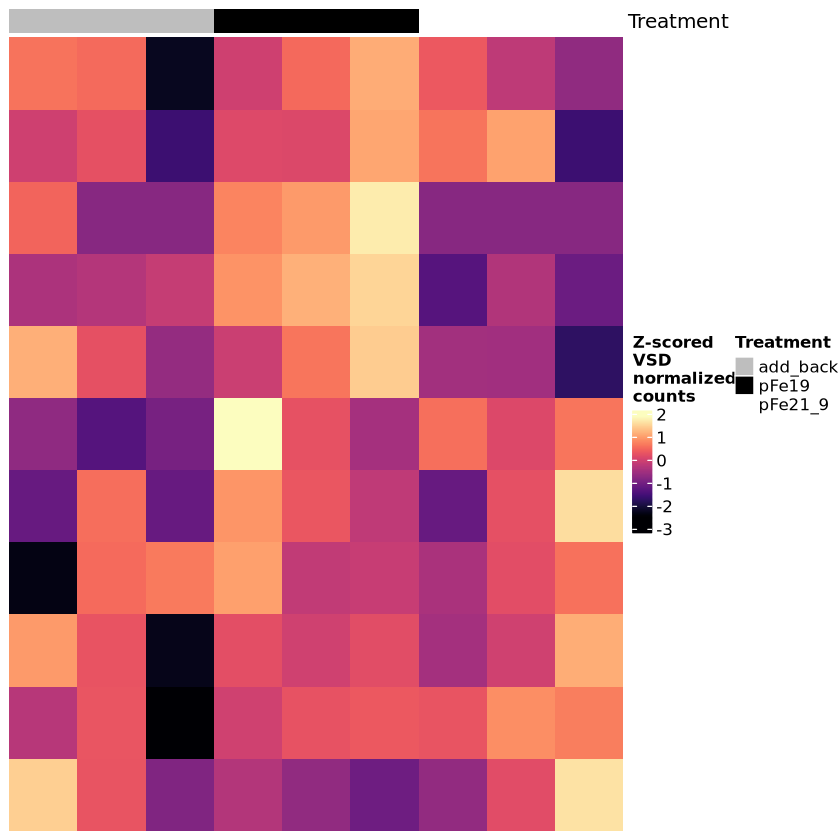

In [25]:
mat_var <- column_to_rownames(rho13,'orfs' )%>% as.matrix #turn into matrix
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #z-score

    col.anno <- data.frame('id' = colnames(rho13)[-1])
    col.anno$Treatment <- str_extract(col.anno$id, '((pFe\\d{1,2}|add)_(9|back)|pFe19)')
    col.anno <- HeatmapAnnotation(
        Treatment=col.anno$Treatment, 
        col = list(Treatment=c('pFe19' = "black", 'pFe21_9' = "white", 'add_back' = "grey"))) 

    ht = Heatmap(mat_var,cluster_columns = F, 
                 cluster_rows=T, show_row_dend = F,
                # column_title = paste(name),
           show_column_names = FALSE,
                 col=magma(100),
            show_row_names = F, 
            top_annotation = col.anno, 
            heatmap_legend_param=list(title="Z-scored \nVSD \nnormalized \ncounts",
                                        position='topcenter'))
draw(ht)

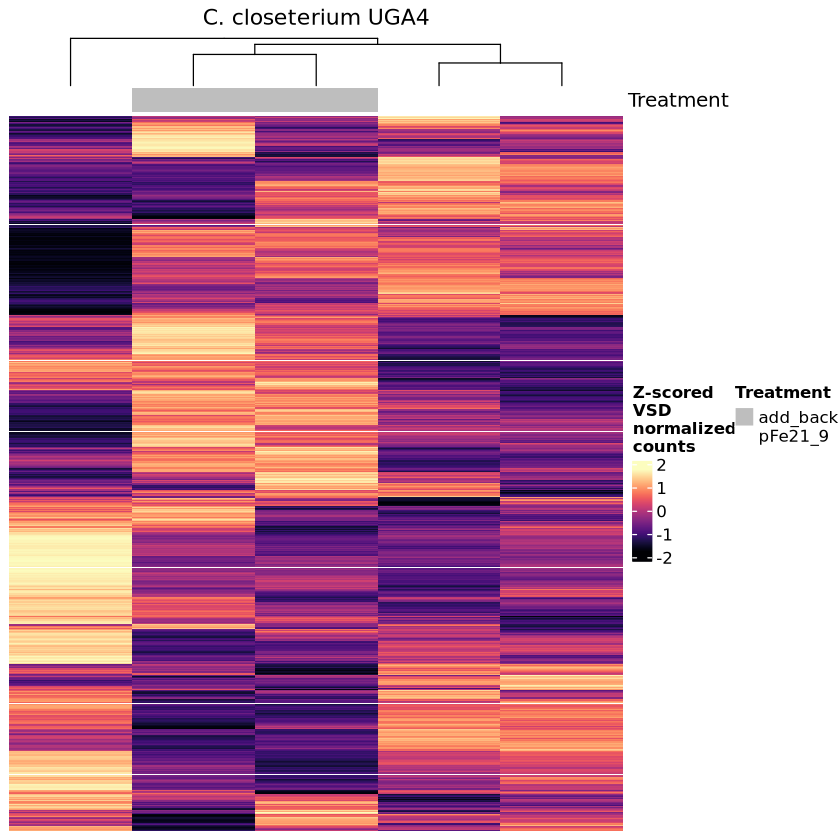

In [16]:
heat.all=function(vsd, org, name){
    mat_var <- column_to_rownames(vsd,'ko_id' )%>% as.matrix #turn into matrix
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #z-score

    col.anno <- data.frame('id' = colnames(vsd)[-1])
    col.anno$Organism <- str_extract(col.anno$id, '\\d{1,2}')
    col.anno$Treatment <- str_extract(col.anno$id, '((pFe\\d{1,2}|add)_(9|back)|pFe19)')
    col.anno$rep <- str_extract(col.anno$id, '[ABC]')
    col.anno <- HeatmapAnnotation(
        Treatment=col.anno$Treatment, 
        col = list(Treatment=c('pFe19' = "black", 'pFe21_9' = "white", 'add_back' = "grey"))) 

   # png(file = paste('../figs/heat.k.all.', org, '.png', sep=''),width = 600,height = 800)
    ht = Heatmap(mat_var,cluster_columns = T, 
                 cluster_rows=T, show_row_dend = F,
                 column_title = paste(name), #'all Kegg genes', sep='\n'),
           show_column_names = FALSE,
                 col=magma(100),
            show_row_names = F, 
            top_annotation = col.anno, 
            heatmap_legend_param=list(title="Z-scored \nVSD \nnormalized \ncounts",
                                        position='topcenter'))
    
    draw(ht)
   # dev.off()
    ht
}
all.4 = heat.all(vsd.4.k, '04', 'C. closeterium UGA4')


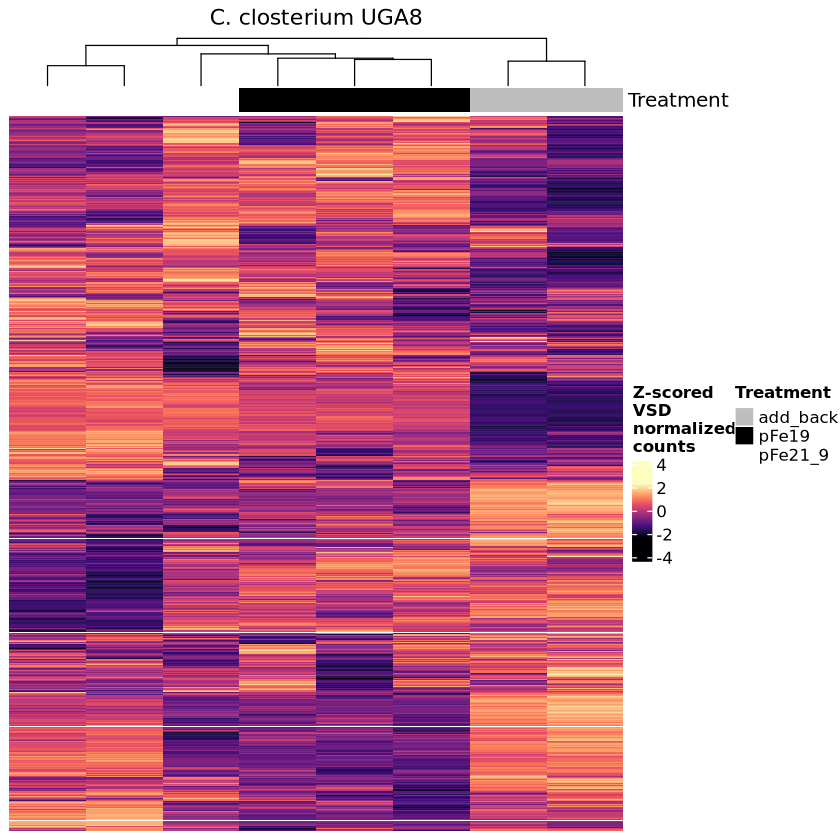

In [33]:
all.8 = heat.all(vsd.8.k, '08', 'C. closterium UGA8')

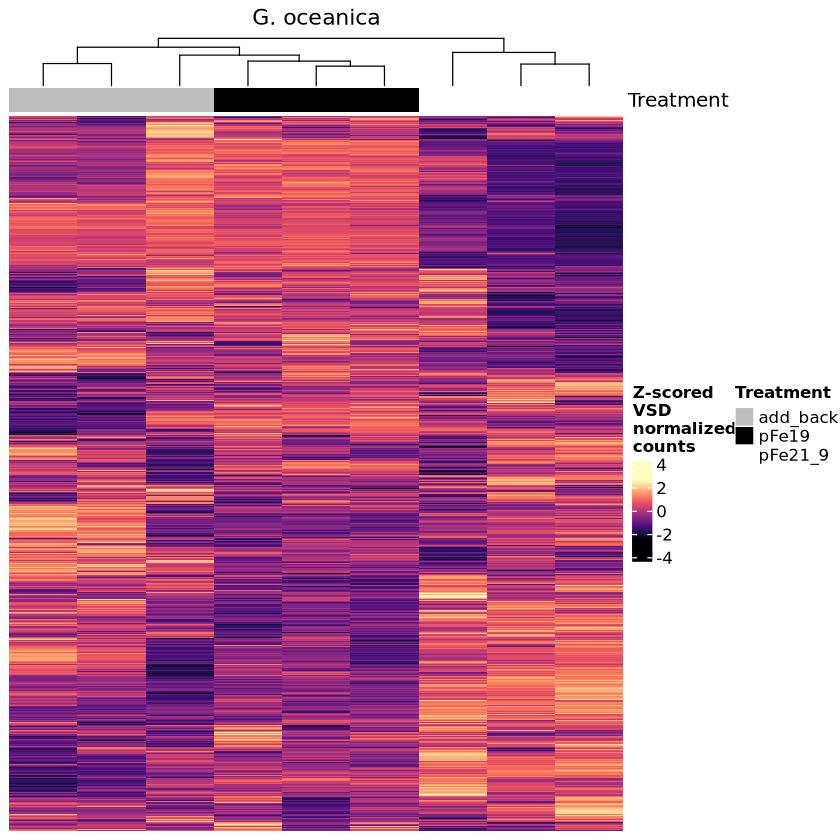

In [34]:
all.6 = heat.all(vsd.6.k, '06', 'G. oceanica')

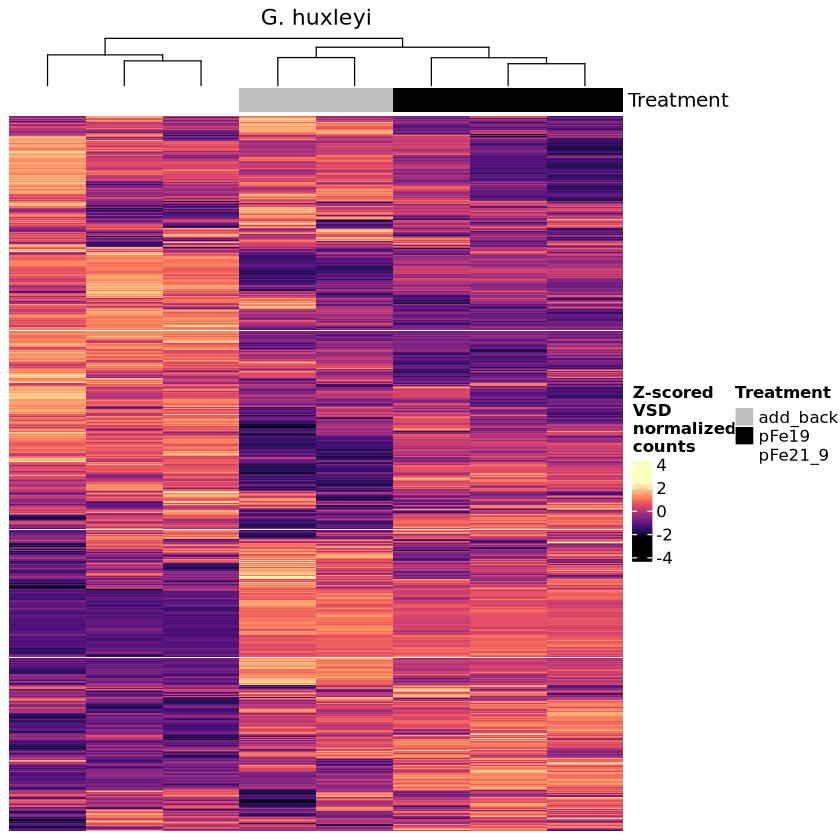

In [17]:
all.13 = heat.all(vsd.13.k, '13', 'G. huxleyi')

In [36]:
all_heat=all.8+all.4+all.6+all.13
draw(all_heat, 
    heatmap_legend_side='bottom',merge_legends=T)

ERROR: Error: `nrow` of all heatmaps and `nobs` of all annotations should be the same
for horizontal heatmap list.
  heatmap 'matrix_2': 3033
  heatmap 'matrix_1': 3149


## Kegg-summed orfs 

In [37]:
set.seed(123)
pvalue = 10^-runif(10, min = 0, max = 3)
is_sig = pvalue < 0.01
pch = rep("*", 10)
pch[!is_sig] = ''
pch
is_sig

[1] ""  "*" ""  "*" "*" ""  ""  "*" ""  ""

[1] FALSE  TRUE FALSE  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE

In [38]:
heat.map <- function(vsd, org, name){
    vsd <- vsd[0:50,] #subset top 30 genes
    mat_var <- column_to_rownames(vsd,'ko_id' )%>% as.matrix #turn into matrix
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) #z-score

    col.anno <- data.frame('id' = colnames(vsd)[-1])
    col.anno$Organism <- str_extract(col.anno$id, '\\d{1,2}')
    col.anno$Treatment <- str_extract(col.anno$id, '((pFe\\d{1,2}|add)_(9|back)|pFe19)')
    col.anno$rep <- str_extract(col.anno$id, '[ABC]')
    col.anno <- HeatmapAnnotation(Treatment=col.anno$Treatment, col = list(Treatment=c(
            'pFe19' = "black", 
            'pFe21_9' = "white", 
            'add_back' = "grey"))) 
    
    row_names <- left_join(vsd, ko.def, by='ko_id') %>%
                        select('ko_id', 'symbol', 'name')
   new_names <- structure(row_names$symbol,  names=row_names$ko_id) #rename rows with kegg symbols

    
   png(file = paste('../figs/heat.top.', org, '.png', sep=''),width = 800,height = 800)
    
   ht=Heatmap(mat_var,cluster_columns = FALSE,column_title = name,
              col=viridis(1000),
           show_column_names = FALSE,
            row_labels = new_names[rownames(mat_var)],
            top_annotation = col.anno, #right_annotation=row.anno,
            row_names_gp = gpar(fontsize = 10),
            clustering_method_rows = "complete",
            heatmap_legend_param=list(title="Z-scored \nVSD \nnormalized \ncounts",
                                        position='topcenter'))
    
    draw(ht)
    dev.off()
    ht
    
}

 heat.map(vsd.4.k, '04', 'C. closterium 4')


ERROR: Error in grid.Call(C_getEngineDLon): could not open file '../figs/heat.top.04.png'


In [39]:
heat.map(vsd.8.k, '08', 'C. closterium 8')

ERROR: Error in grid.Call(C_getEngineDLon): could not open file '../figs/heat.top.08.png'


In [ ]:
heat.map(vsd.6.k, '06', 'G. oceanica')

In [ ]:

heat.map(vsd.13.k, '13', 'G. huxleyi')

## Protein-specific heatmaps
<b/>Using module and pathway df's created in kegg script.</b>
### 1. Create a table with significance from DE.


In [6]:

get.sig=function(HIGH,ADD){
    hvl.sig=filter(HIGH, padj<0.05)
    hvl.sig=data.frame('ko_id'=hvl.sig$ko_id, 'HvL'='*')
    avl.sig=filter(ADD, padj<0.05)
    avl.sig=data.frame('ko_id'=avl.sig$ko_id, 'AvL'='*')
    sig.ko=full_join(hvl.sig, avl.sig)
    ko.missing=ko.def[(ko.def$ko_id%in%sig.ko$ko_id==F), ]
    ko.missing=data.frame(ko_id=ko.missing$ko_id, 'HvL'=' ','AvL'=' ')
    sig.final=bind_rows(sig.ko, ko.missing)
    #sig.final=filter(sig.final,(ko_id %in% ko.def$ko_id))
    sig.final[is.na(sig.final)]=' '
    sig.final
    }
sig.ko13=get.sig(lfc13.k.HvL,lfc13.k.AvL)
sig.ko8=get.sig(lfc8.k.HvL, lfc8.k.AvL)
sig.ko6=get.sig(lfc6.k.HvL, lfc6.k.AvL)
sig.ko4={
    avl.sig=filter(lfc4.k.AvL, padj<0.05)
    sig.ko=data.frame('ko_id'=avl.sig$ko_id,'HvL'=' ', 'AvL'='*')
    ko.missing=ko.def[(ko.def$ko_id%in%sig.ko$ko_id==F), ]
    ko.missing=data.frame(ko_id=ko.missing$ko_id, 'HvL'=' ','AvL'=' ')
    sig.final=bind_rows(sig.ko, ko.missing)
    #sig.final=filter(sig.final,(ko_id %in% ko.def$ko_id))
    sig.final[is.na(sig.final)]=' '
    sig.final}


Joining with `by = join_by(ko_id)`
Joining with `by = join_by(ko_id)`
Joining with `by = join_by(ko_id)`


### 2. Make preliminary annotations

In [7]:
####      call these functions in figure making functions to make the row and column annotations ####

col.anno = function(vsd, org){
    col.anno <- data.frame('id' = colnames(vsd)[-1])
    col.anno <- data.frame('id'=col.anno$id,
                           'Treatment'=str_extract(col.anno$id,'((pFe\\d{1,2}|add)_(9|back)|pFe19)'))
    if (org=='Gephyrocapsa \nhuxleyi'){
        col.org <- "#3456CA"
        isolate='13'
    }else if (org=='Gephyrocapsa \noceanica'){
        col.org <- "#90A1DA"
        isolate='06'
    }else if (org=='Cylindrotheca \nclosterium UGA4'){
        col.org <- "#0F6104"
        isolate='04'
    }else{
        col.org <- "#9AB18D"
        isolate='08'}
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
    
    col.anno <- HeatmapAnnotation(
        'Isolate'=anno_block(
            gp=gpar(fill=col.org, col=col.org),
            labels=org,
            labels_gp=gpar(fontface='bold.italic', col='black', fontsize=25)),
        'Treatment'=anno_simple(col.anno$Treatment, 
            col = c(
                 'pFe19' = "black",
                 'pFe21_9' = "white",
                  'add_back' = "grey")),
        annotation_name_gp=gpar(fontsize=25),
        show_annotation_name=legend.show) }



### 3. Set up Pathway data 
#### I. Read in Module and Pathway information.
This will subset genes (KO's) by the pathway or module associated with them.


#### II. Filter list for genes expressed by isolates
Not all ko's in each path will be expressed, filter out those so that pathway lists contain ko's expressed by at least one organism

#### III. Adjust subcategory names and gene names for plotting later

In [29]:
filter(ko.def, ko_id %in% c('K01601','K01602','K19269','K11517','K03781','K14272','K00600','K00830','K15893,K15919','K15918',
                            'K00281','K00605','K00382','K02437'))
filter(all.path, sub_category=='Electron transport chain')

ko_id,symbol,name
<chr>,<chr>,<chr>
K03781,"katE, CAT, catB, srpA",catalase [EC:1.11.1.6]
K00382,"DLD, lpd, pdhD",dihydrolipoyl dehydrogenase [EC:1.8.1.4]
K00600,"glyA, SHMT",glycine hydroxymethyltransferase [EC:2.1.2.1]
K00605,"gcvT, AMT",glycine cleavage system T protein (aminomethyltransferase) [EC:2.1.2.10]
K01601,"rbcL, cbbL",ribulose-bisphosphate carboxylase large chain [EC:4.1.1.39]
K00281,"GLDC, gcvP",glycine cleavage system P protein (glycine dehydrogenase) [EC:1.4.4.2]
K19269,"PGP, PGLP",phosphoglycolate phosphatase [EC:3.1.3.18 3.1.3.48]
K02437,"gcvH, GCSH",glycine cleavage system H protein
K11517,HAO,(S)-2-hydroxy-acid oxidase [EC:1.1.3.15]


Path,ko_id,symbol,name,sub_category,path_name,broad_category,name.2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
map00195,K02634,petA,apocytochrome f,Electron transport chain,Photosynthesis,NA,apocytochrome f
map00195,K02636,petC,cytochrome b6-f complex iron-sulfur subunit,Electron transport chain,Photosynthesis,NA,cytochrome b6f iron-sulfur subunit
map00195,K02639,petF,ferredoxin,Electron transport chain,Photosynthesis,NA,ferredoxin
map00195,K02641,petH,ferredoxin--NADP+ reductase,Electron transport chain,Photosynthesis,NA,ferredoxin--NADP+ reductase
map00195,K08906,petJ,cytochrome c6,Electron transport chain,Photosynthesis,NA,cytochrome c6
map00195,K03839,"fldA, nifF, isiB",flavodoxin I,Electron transport chain,Photosynthesis,NA,flavodoxin I
map00195,K00528,fpr,ferredoxin/flavodoxin---NADP+ reductase,Electron transport chain,Photosynthesis,NA,ferredoxin/flavodoxin---NADP+ reductase


In [27]:
col_fun=colorRamp2(c(-2,0,2), hcl_palette ='Inferno')                             
ld1=Legend(col_fun = col_fun, title="Z-scored VST\nnormalized\ncounts", 
           labels_gp=gpar(fontsize=30), title_gp=gpar(fontsize=35,fontface='bold'), direction='horizontal')
ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
           labels_gp=gpar(fontsize=30),grid_width=unit(0.7,'cm'),
           title_gp=gpar(fontsize=35, fontface='bold'),
           title='Treatment', direction='horizontal')
ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
           labels_gp=gpar(fontsize=30),
           title_gp=gpar(fontsize=35,fontface='bold'))
                           
sub.path.heat = function(mp, vsd, org, sig.ko){
    #filter our ko's for pathway of interest
    select.cat=filter(all.path, path_name==mp)
    select.cat=select.cat %>% group_by(sub_category)
    select.cat = select.cat %>% arrange(sub_category, ko_id)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)=='sub_category')]
    rownames(vsd.cat)=NULL
    
    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  #mat_var <- mat_var[sort(rownames(mat_var)),]
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL, gp = gpar(fontsize=30), show_name=TRUE), 
        ' High'=anno_text(sig.expressed$HvL, gp = gpar(fontsize=30), show_name=TRUE),
    annotation_name_gp=gpar(fontsize=20))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, col=inferno(100), 
               row_labels = new_names[rownames(mat_var)], row_names_gp = gpar(fontsize = 20), cluster_rows=FALSE,
               cluster_columns=FALSE, show_column_names=FALSE,
               top_annotation = col.anno, 
               right_annotation=row.anno,
               na_col = 'lightgrey')
   ht
    
   }

sub.cat.anno = function(path,col_list){
    sub_cat_leg= filter(all.path, path_name==path) %>% group_by(sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', col=col_list,
           show_column_names=F, show_heatmap_legend=F, row_names_gp = gpar(fontsize = 20))
    ht
    }

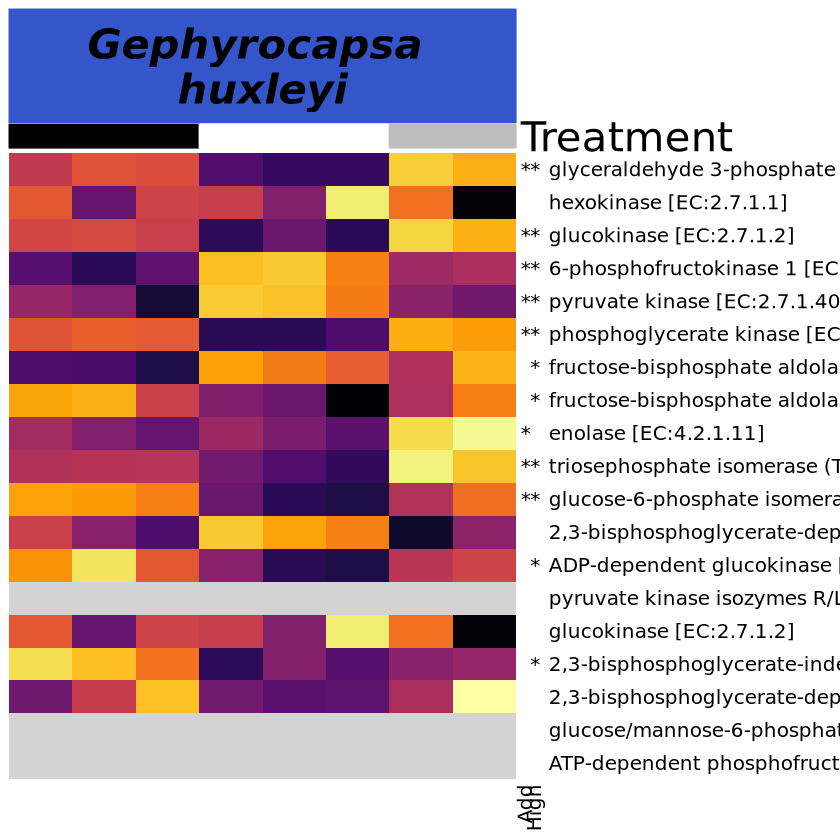

In [28]:
col_fun=colorRamp2(c(-2,0,2), hcl_palette ='Inferno')          

ld1=Legend(col_fun = col_fun, title="Z-scored VSD\nnormalized\ncounts", 
           title_gp=gpar(fontface='bold', fontsize=25),
           title_position='topcenter', direction='horizontal')

ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
            title_gp=gpar(fontface='bold'),
           grid_width=unit(0.7,'cm'),title='Treatment', direction='horizontal')

ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
            title_gp=gpar(fontface='bold'))
#photoresp= c('K01596','K01610','K01689','K01834','K15633','K15634','K15635','K00927','K00134','K00150',
 #           'K01803','K01623','K01624','K11645','K03841','K02446','K11532','K01086','K04041','K01622')

photoresp=c('K00844','K12407','K00845','K25026','K00886','K08074','K00918','K01810','K06859','K13810','K15916',
            'K00850','K16370','K21071','K00918','K01623','K01624','K11645','K16305','K16306','K01803',
            'K00134','K00150','K00927','K11389','K01834','K15633','K15634','K15635','K01689','K00873','K12406')
all.path.heat = function(vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(ko.def, ko_id%in%photoresp)
    select.cat = select.cat %>% arrange(ko_id)
     #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name, names=select.cat$ko_id)
    
    vsd.cat = vsd.cat %>% arrange(ko_id)
    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix     
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var) 
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE),  
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, 
               col=inferno(100), 
               row_labels = new_names[rownames(mat_var)],
               cluster_row_slices=F, row_title_gp = gpar(fontface='bold'),
               cluster_columns = FALSE,
               cluster_rows=FALSE,
               show_column_names = FALSE,
               top_annotation = col.anno, 
               right_annotation=row.anno,
               na_col = 'lightgrey')
   ht
    
   }


all.4=all.path.heat(vsd=vsd.4.k,org = 'Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
all.8=all.path.heat(vsd=vsd.8.k,org = 'Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
all.6=all.path.heat(vsd=vsd.6.k,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
all.13=all.path.heat(vsd=vsd.13.k,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)


all.list=all.8+all.4+all.6+all.13
draw(all.list)
draw(all.8+all.4)
draw(all.13)

## make all pathways into one heatmap

In [37]:
all.path$name.2 = str_replace_all(all.path$name.2, 
                c('nitrate/nitrite transport substrate-binding protein'='nitrate/nitrite transport substrate-binding',
                  'nitrate/nitrite transport ATP-binding protein C'='nitrate/nitrite transport ATP-binding C')) 

In [41]:
all.path$name.2 = str_replace(all.path$name.2, 'glyceraldehyde 3-phosphate.*','glyceraldehyde 3-phosphate\ndehydrogenase')
all.path$name.2 = str_replace(all.path$name.2, 'solute carrier family 14.*', 'urea transporter (SLC14A)')


In [42]:
np=filter(all.path, path_name=='Nitrogen metabolism')
(arrange(np,sub_category, name.2))

Path,ko_id,symbol,name,sub_category,path_name,broad_category,name.2
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
map00910,K01672,CA,carbonic anhydrase,Carbonic anhydrase,Nitrogen metabolism,NA,carbonic anhydrase
map00910,K01673,"cynT, can",carbonic anhydrase,Carbonic anhydrase,Nitrogen metabolism,NA,carbonic anhydrase 1
map00910,K01674,cah,carbonic anhydrase,Carbonic anhydrase,Nitrogen metabolism,NA,carbonic anhydrase 2
map00910,K15371,GDH2,glutamate dehydrogenase,GDH,Nitrogen metabolism,NA,glutamate dehydrogenase
map00910,K00262,"E1.4.1.4, gdhA",glutamate dehydrogenase (NADP+),GDH,Nitrogen metabolism,NA,glutamate dehydrogenase (NADP+)
map00910,K00264,GLT1,glutamate synthase (NADH),GS/GOGAT,Nitrogen metabolism,NA,glutamate synthase (NADH)
map00910,K00265,gltB,glutamate synthase (NADPH) large chain,GS/GOGAT,Nitrogen metabolism,NA,glutamate synthase (NADPH) large chain
map00910,K00266,gltD,glutamate synthase (NADPH) small chain,GS/GOGAT,Nitrogen metabolism,NA,glutamate synthase (NADPH) small chain
map00910,K00284,"GLU, gltS",glutamate synthase (ferredoxin),GS/GOGAT,Nitrogen metabolism,NA,glutamate synthase (ferredoxin)


In [43]:
col_fun=colorRamp2(c(-2,0,2), hcl_palette ='Inferno')          

ld1=Legend(col_fun = col_fun, title="Z-scored VSD\nnormalized\ncounts", 
           title_gp=gpar(fontface='bold', fontsize=30), labels_gp=gpar(fontsize=25),
           title_position='topcenter', direction='horizontal')

ld2=Legend(labels=c('High iron','Low iron','Iron amendment'),
           legend_gp=gpar(fill=c('High iron'='black','Low iron'='white','Iron amendment'='grey')),
           labels_gp=gpar(fontsize=25), title_gp=gpar(fontface='bold', fontsize=30),
           grid_width=unit(0.7,'cm'),title='Treatment', direction='horizontal')

ld3=Legend(labels="< 0.05", title='Significance', type='points', pch=8,
           labels_gp=gpar(fontsize=30), title_gp=gpar(fontface='bold', fontsize=30))

all.path.heat = function(subs, vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, sub_category%in%subs)
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, name.2)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    #create ordered vector of ko symbols to use as row names
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE, gp = gpar(fontsize=50)),  
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE, gp = gpar(fontsize=50)), 
    annotation_name_gp=gpar(fontsize=30))
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, 
               col=inferno(100), row_split=factor(select.cat$path_name,levels=c('Photosynthesis', 'Nitrogen metabolism')),
               row_labels = new_names[rownames(mat_var)], 
               row_gap=unit(1, 'cm'), cluster_row_slices=F, row_title_gp = gpar(fontsize=50,fontface='bold'),
               cluster_columns = FALSE, cluster_rows=FALSE, show_column_names = FALSE,
               top_annotation = col.anno, right_annotation=row.anno, na_col = 'lightgrey')
   ht
    
   }

sub.cat.anno = function(subs,col_list){
    sub_cat_leg= filter(all.path, sub_category%in%subs) %>% group_by(path_name,sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(desc(path_name), sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', col=col_list, 
               row_split=factor(sub_cat_leg$path_name, levels=c('Photosynthesis', 'Nitrogen metabolism')),
               row_gap=unit(1,'cm'), cluster_row_slices=F,
               show_column_names=F, show_heatmap_legend=F,
                row_names_gp = gpar(fontsize = 30))
    ht
    }


In [44]:
#unique(all.path$sub_category)
sub_cat=c('Electron transport chain','ISIP','PSI','PSII','Superoxide dismutase','Xanthophyll cycle',
          'GDH','GS/GOGAT','Nitrate/Nitrite reductase','Nitrogen recycling','Nitrogen transporters','Urea cycle')
sub_col=c('Electron transport chain'='#284026',
          'ISIP'='#1A8118',
          'PSI'='#A39F24',
          'PSII'='#FFD666',
          'Superoxide dismutase'='#FE8E3E',
          'Xanthophyll cycle'='#882216',
          'GDH'='#EB0014',
          'GS/GOGAT'='#FF7ADC',
          'Nitrate/Nitrite reductase'='#A90AFF',
          'Nitrogen recycling'='#8E7AFF',
          'Nitrogen transporters'='#330AFF',
          'Urea cycle'='#00046B'
           )
ld4 = Legend(labels=c('Electron transport chain','ISIP','PSI','PSII','Superoxide dismutase','Xanthophyll cycle',
          'GDH','GS/GOGAT','Nitrate/Nitrite reductase','Nitrogen recycling','Nitrogen transporters','Urea cycle'),
             legend_gp=gpar(fill=sub_col), grid_width=unit(0.7,'cm'),
             labels_gp=gpar(fontsize=25),
             title_gp=gpar( fontface='bold',fontsize=30),
             title='Module', ncol=3,
            title_position='topcenter', gap=unit(2,'cm'))


all.4=all.path.heat(subs=sub_cat,vsd=vsd.4.k,org = 'Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
all.8=all.path.heat(subs=sub_cat,vsd=vsd.8.k,org = 'Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
all.6=all.path.heat(subs=sub_cat,vsd=vsd.6.k,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
all.13=all.path.heat(subs=sub_cat,vsd=vsd.13.k,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)

all.cat=sub.cat.anno(sub_cat, sub_col)
all.list=all.8+all.4+all.6+all.13+all.cat

png('../figures/Fig4_heatmap.png', width=2500, height=2300)
draw(all.list, annotation_legend_list=packLegend(ld1,ld2,ld3,ld4, direction='horizontal', column_gap = unit(1.8, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,170), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`


 [1] "Electron transport chain"  "ISIP"                     
 [3] "PSI"                       "PSII"                     
 [5] "Superoxide dismutase"      "Xanthophyll cycle"        
 [7] "GDH"                       "GS/GOGAT"                 
 [9] "Nitrate/Nitrite reductase" "Nitrogen recycling"       
[11] "Nitrogen transporters"     "Urea cycle"               


png 
  2

In [47]:
all.4[-10,]

ERROR while rich displaying an object: Error: Number of rows in the matrix are not the same as the length of the
cluster or the row orders.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_

In [101]:
carbon.heat = function(vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, sub_category%in%c('CAM dark','CAM light','C4 Dicarboxilic acid cycle',
                                                  'Calvin cycle','Carbonic anhydrase'))
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, ko_id)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    #create ordered vector of ko symbols to use as row names
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE, gp = gpar(fontsize=50)),  
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE, gp = gpar(fontsize=50)), 
    annotation_name_gp=gpar(fontsize=30))
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F, 
               col=inferno(100), 
               row_labels = new_names[rownames(mat_var)], 
              cluster_row_slices=F, 
               cluster_columns = FALSE, cluster_rows=FALSE, show_column_names = FALSE,
               top_annotation = col.anno, right_annotation=row.anno, na_col = 'lightgrey')
   ht
    
   }

carbon.cat = {
    sub_cat_leg= filter(all.path, sub_category%in%c('CAM dark','CAM light','C4 Dicarboxilic acid cycle',
                                                    'Calvin cycle','Carbonic anhydrase')) %>% 
    group_by(path_name,sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(desc(path_name), sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', 
               col=c('CAM dark'='darkblue','CAM light'='lightblue','C4 Dicarboxilic acid cycle'='lightgreen',
        'Calvin cycle'='darkgreen','Carbonic anhydrase'='pink'), 
               cluster_row_slices=F,
               show_column_names=F, show_heatmap_legend=F,
                row_names_gp = gpar(fontsize = 30))
    ht
    }

c_sub=c('CAM dark','CAM light','C4 Dicarboxilic acid cycle','Calvin cycle','Carbonic anhydrase')
c_col=c('CAM dark'='darkblue','CAM light'='lightblue','C4 Dicarboxilic acid cycle'='lightgreen',
        'Calvin cycle'='darkgreen','Carbonic anhydrase'='pink')

carbon.4=carbon.heat(vsd=vsd.4.k,org = 'Cylindrotheca \nclosterium UGA4',sig.ko = sig.ko4)
carbon.8=carbon.heat(vsd=vsd.8.k,org = 'Cylindrotheca \nclosterium UGA8',sig.ko = sig.ko8)
carbon.6=carbon.heat(vsd=vsd.6.k,org = 'Gephyrocapsa \noceanica',sig.ko = sig.ko6)
carbon.13=carbon.heat(vsd=vsd.13.k,org = 'Gephyrocapsa \nhuxleyi',sig.ko = sig.ko13)


carbon.list=carbon.8+carbon.4+carbon.6+carbon.13+carbon.cat

c.ld4 = Legend(labels=c('CAM dark','CAM light','C4 Dicarboxilic acid cycle','Calvin cycle','Carbonic anhydrase'),
             legend_gp=gpar(fill=c_col), grid_width=unit(0.7,'cm'),
             labels_gp=gpar(fontsize=25),
             title_gp=gpar( fontface='bold',fontsize=25),
             title='Module', ncol=3,
            title_position='topcenter', gap=unit(2,'cm'))

png('../figures/SFig6_carbonHeatmap.png', width=2500, height=2300)
draw(carbon.list, annotation_legend_list=packLegend(ld1,ld2,ld3,c.ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(10,2,2,170), 'mm'), adjust_annotation_extension=TRUE)
dev.off()


[1] "Carbonic anhydrase"         "C4 Dicarboxilic acid cycle"
[3] "CAM dark"                   "CAM light"                 
[5] "Calvin cycle"              


Adding missing grouping variables: `path_name`, `sub_category`
There are 100 unique colors in the vector `col` and 100 unique values
in `matrix`. `Heatmap()` will treat it as an exact discrete one-to-one
mapping. If this is not what you want, slightly change the number of
colors, e.g. by adding one more color or removing a color.

Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`
Adding missing grouping variables: `path_name`, `sub_category`


png 
  2

## Make smaller heatmaps for talk

In [ ]:
filter(all.path, path_name=='Photosynthesis')

In [ ]:
#select genes by ko_id or name then build heatmap
## for photosynthesis 10 genes pulled out
photo_talk=c('K08902','K08903','K02719','K08914','K08916','K09838','K09839','K04564','K04565')

talk.heat = function(ko, vsd, org, sig.ko){
    #filter out ko's for pathway of interest
    select.cat=filter(all.path, ko_id%in%ko)
    select.cat=select.cat %>% group_by(path_name, sub_category)
    select.cat = select.cat %>% arrange(desc(path_name), sub_category, ko_id)
    #filter genes expressed in path
    genes.expressed <- vsd %>% filter(ko_id %in% select.cat$ko_id)
    # path genes not found in sample 
    genes.missing <- select.cat %>% filter(ko_id %in% vsd$ko_id==F) %>% select('ko_id')
    #  dataframe including genes not found replaced with an NA
    vsd.cat <- bind_rows(genes.expressed,genes.missing) 
    
    #create ordered vector of ko symbols to use as row names
    new_names= structure(select.cat$name.2, names=select.cat$ko_id)
 
    vsd.cat = vsd.cat[match(select.cat$ko_id, vsd.cat$ko_id),-which(names(vsd.cat)%in%c('path_name','sub_category'))]
    rownames(vsd.cat)=NULL

    mat_var <- column_to_rownames(vsd.cat,'ko_id' )%>% as.matrix 
    mat_var <- (mat_var - rowMeans(mat_var) ) / rowSds(mat_var)  
    #call function to make column annotation
    col.anno <- col.anno(vsd = vsd, org=org) 
    #call function to make row annotation
    sig.expressed=filter(sig.ko, ko_id%in%vsd.cat$ko_id)
    sig.expressed = sig.expressed[match(vsd.cat$ko_id, sig.expressed$ko_id),]
    row.anno <- rowAnnotation(
        ' Add'=anno_text(sig.expressed$AvL,show_name=TRUE, gp = gpar(fontsize=50)),  
        ' High'=anno_text(sig.expressed$HvL, show_name=TRUE, gp = gpar(fontsize=50)), 
    annotation_name_gp=gpar(fontsize=30))
    
    if (org == "Gephyrocapsa \nhuxleyi"){
                legend.show=TRUE
            }else{legend.show=FALSE}
   
    ht=Heatmap(mat_var,show_heatmap_legend = F,  col=inferno(100),row_labels = new_names[rownames(mat_var)], 
               cluster_columns = FALSE, cluster_rows=FALSE, show_column_names = FALSE,
               top_annotation = col.anno, right_annotation=row.anno, na_col = 'lightgrey')
   ht
    
   }

sub.cat.anno = function(ko,col_list){
    sub_cat_leg= filter(all.path, ko_id%in%ko) %>% group_by(path_name,sub_category)
    sub_cat_leg = sub_cat_leg %>% arrange(desc(path_name), sub_category, ko_id)
    sub_cat_mat=sub_cat_leg$sub_category
    print(unique(sub_cat_leg$sub_category))
    names(sub_cat_mat)=sub_cat_leg$name.2
    
    ht=Heatmap(sub_cat_mat, name='Subcategory', col=col_list, 
                show_column_names=F, show_heatmap_legend=F,
                row_names_gp = gpar(fontsize = 30))
    ht
    }

photo_col=c('PSII'='#8A8EFF', 'Superoxide dismutase'='#060EE2','Xanthophyll cycle'='#050856')

p.talk.4 = talk.heat(photo_talk, vsd.4.k, 'Cylindrotheca \nclosterium UGA4', sig.ko4)
p.talk.8 = talk.heat(photo_talk, vsd.8.k, 'Cylindrotheca \nclosterium UGA8', sig.ko8)
p.talk.6 = talk.heat(photo_talk, vsd.6.k, 'Gephyrocapsa \noceanica', sig.ko6)
p.talk.13 = talk.heat(photo_talk, vsd.13.k, 'Gephyrocapsa \nhuxleyi', sig.ko13)

p.talk.cat = sub.cat.anno(photo_talk, photo_col)
p.talk.list = p.talk.8 + p.talk.4 + p.talk.6 + p.talk.13 + p.talk.cat

p.talk.ld4 = Legend(labels=c('PSII','Superoxide dismutase','Xanthophyll cycle'),
             legend_gp=gpar(fill=photo_col), grid_width=unit(0.7,'cm'), labels_gp=gpar(fontsize=30),
             title_gp=gpar( fontface='bold',fontsize=35), title='Module', title_position='topcenter')

png('../figs/short_photo_heatmap.png', width=2500, height=1000)
draw(p.talk.list, annotation_legend_list=packLegend(ld1,ld2,ld3,p.talk.ld4, direction='horizontal', column_gap = unit(1.5, 'cm')),
    heatmap_legend_side='bottom', merge_legends=T, padding=unit(c(2,2,2,80), 'mm'), adjust_annotation_extension=TRUE)
dev.off()

In [ ]:
sessionInfo()